In [2]:
!pip install facenet_pytorch
!pip install transformers
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import cv2
import torch
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from deepface import DeepFace

In [5]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cpu'

In [6]:
# video_path =  '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/titanic.mp4'
# video_path = 'https://youtu.be/1pLuJVmdehg'
video_path = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/project.mp4'
# video_path = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/sad.mp4'

In [199]:
v_cap = cv2.VideoCapture(video_path)
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))


class FaceDetector(object):
    """
    Face detector class
    """
      
    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.extractor = AutoFeatureExtractor.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model = AutoModelForImageClassification.from_pretrained("Rajaram1996/FacialEmoRecog")
        self.emotion_model.eval()
        self.soft_max = torch.nn.Softmax(dim=0)
        self.faces_list = []
        self.face_image_limit = 70
        self.frames = []
        self.frame_nums = []


    def predict_emotion(self, image_num):

        inputs = self.extractor(self.faces_list[image_num][0], return_tensors="pt")

        with torch.no_grad():
            logits = self.emotion_model(**inputs).logits

        variances = self.soft_max(logits[0])

        # model predicts one of the 1000 ImageNet classes
        predicted_label = variances.argmax(-1).item()
        
        print(plt.imshow(self.faces_list[image_num][0]))
        print(f'\nResult {self.emotion_model.config.id2label[predicted_label]} {variances[predicted_label]*100:.4}%')

        for i in range(len(variances)):
            print(f'{self.emotion_model.config.id2label[i]} {variances[i]*100:.4}%')


    def run(self):
        batch_size = 16

        # for frame_num in tqdm(range(v_len)):
        for frame_num in tqdm(range(300)):

            if frame_num % 6 == 0:
                # Load frame
                success, frame = v_cap.read()
                if not success:
                    continue
                    
                # Add to batch
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                self.frames.append(frame)
                self.frame_nums.append(frame_num)

                
                # When batch is full, detect faces and reset batch list
                if len(self.frames) >= batch_size:
                    
                    try:
                        batch_boxes, _, batch_landmarks = self.mtcnn.detect(self.frames, landmarks=True)

                        for boxes, landmarks, frame, real_frame_number in zip(batch_boxes, batch_landmarks, self.frames, self.frame_nums):
                            
                            # several faces in one frame
                            for box, landmark in zip(boxes, landmarks):
                                face_image = frame.crop((int(box[0]), int(box[1]), int(box[2]), int(box[3])))

                                # take faces more than <face_image_limit> pixels in one of the dims
                                if face_image.size[0] > self.face_image_limit and face_image.size[1] > self.face_image_limit:
                                    self.faces_list.append((face_image, real_frame_number))
                        
                    except:
                        pass
                        
                    # обнуляем данные батча
                    self.frames = []
                    self.frame_nums = []

        v_cap.release()
        cv2.destroyAllWindows()

      

In [202]:
%%time
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)
fcd.run()

  0%|          | 0/300 [00:00<?, ?it/s]

[(<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>, 0)]
[(<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>, 0), (<PIL.Image.Image image mode=RGB size=105x136 at 0x7F683EF439D0>, 6)]
[(<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>, 0), (<PIL.Image.Image image mode=RGB size=105x136 at 0x7F683EF439D0>, 6), (<PIL.Image.Image image mode=RGB size=111x139 at 0x7F6844C3C790>, 12)]
[(<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>, 0), (<PIL.Image.Image image mode=RGB size=105x136 at 0x7F683EF439D0>, 6), (<PIL.Image.Image image mode=RGB size=111x139 at 0x7F6844C3C790>, 12), (<PIL.Image.Image image mode=RGB size=112x140 at 0x7F6844AD6B10>, 18)]
[(<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>, 0), (<PIL.Image.Image image mode=RGB size=105x136 at 0x7F683EF439D0>, 6), (<PIL.Image.Image image mode=RGB size=111x139 at 0x7F6844C3C790>, 12), (<PIL.Image.Image image mode=RGB size=112x140 at 0x7F6844AD6B10>, 18), (<PIL.Imag

In [204]:
# fcd.predict_emotion(42)

In [205]:
# foto1 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo1.jpg'
# foto2 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo2.jpg'
# foto3 = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/leo3.jpg'
# super = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/super.jpg'
# people = '/content/drive/MyDrive/05_pytorch/HACKATON_emotions/people.jpg'

In [206]:
# DeepFace.verify(img1_path = foto1, img2_path = foto2)

In [207]:
# DeepFace.verify(img1_path = foto1, img2_path = foto3, enforce_detection=False)

In [208]:
# DeepFace.verify(img1_path = foto2, img2_path = super)

In [209]:
# DeepFace.analyze(img_path = foto1, actions = ['age', 'emotion'])

In [228]:
len(fcd.faces_list)

73

In [211]:
DeepFace.analyze(img_path = np.array(fcd.faces_list[2][0]), actions = ['age', 'emotion'], enforce_detection=False)

Action: emotion: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


{'age': 23,
 'dominant_emotion': 'angry',
 'emotion': {'angry': 34.37740504741669,
  'disgust': 0.5972387734800577,
  'fear': 21.39265239238739,
  'happy': 0.7935881614685059,
  'neutral': 9.039950370788574,
  'sad': 32.08555281162262,
  'surprise': 1.7136158421635628},
 'region': {'h': 111, 'w': 139, 'x': 0, 'y': 0}}

AxesImage(54,36;334.8x217.44)

Result disgust 16.68%
anger 16.34%
contempt 12.73%
disgust 16.68%
fear 6.03%
happy 16.6%
neutral 15.66%
sadness 7.954%
surprise 8.016%


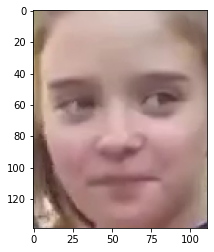

In [212]:
fcd.predict_emotion(2)

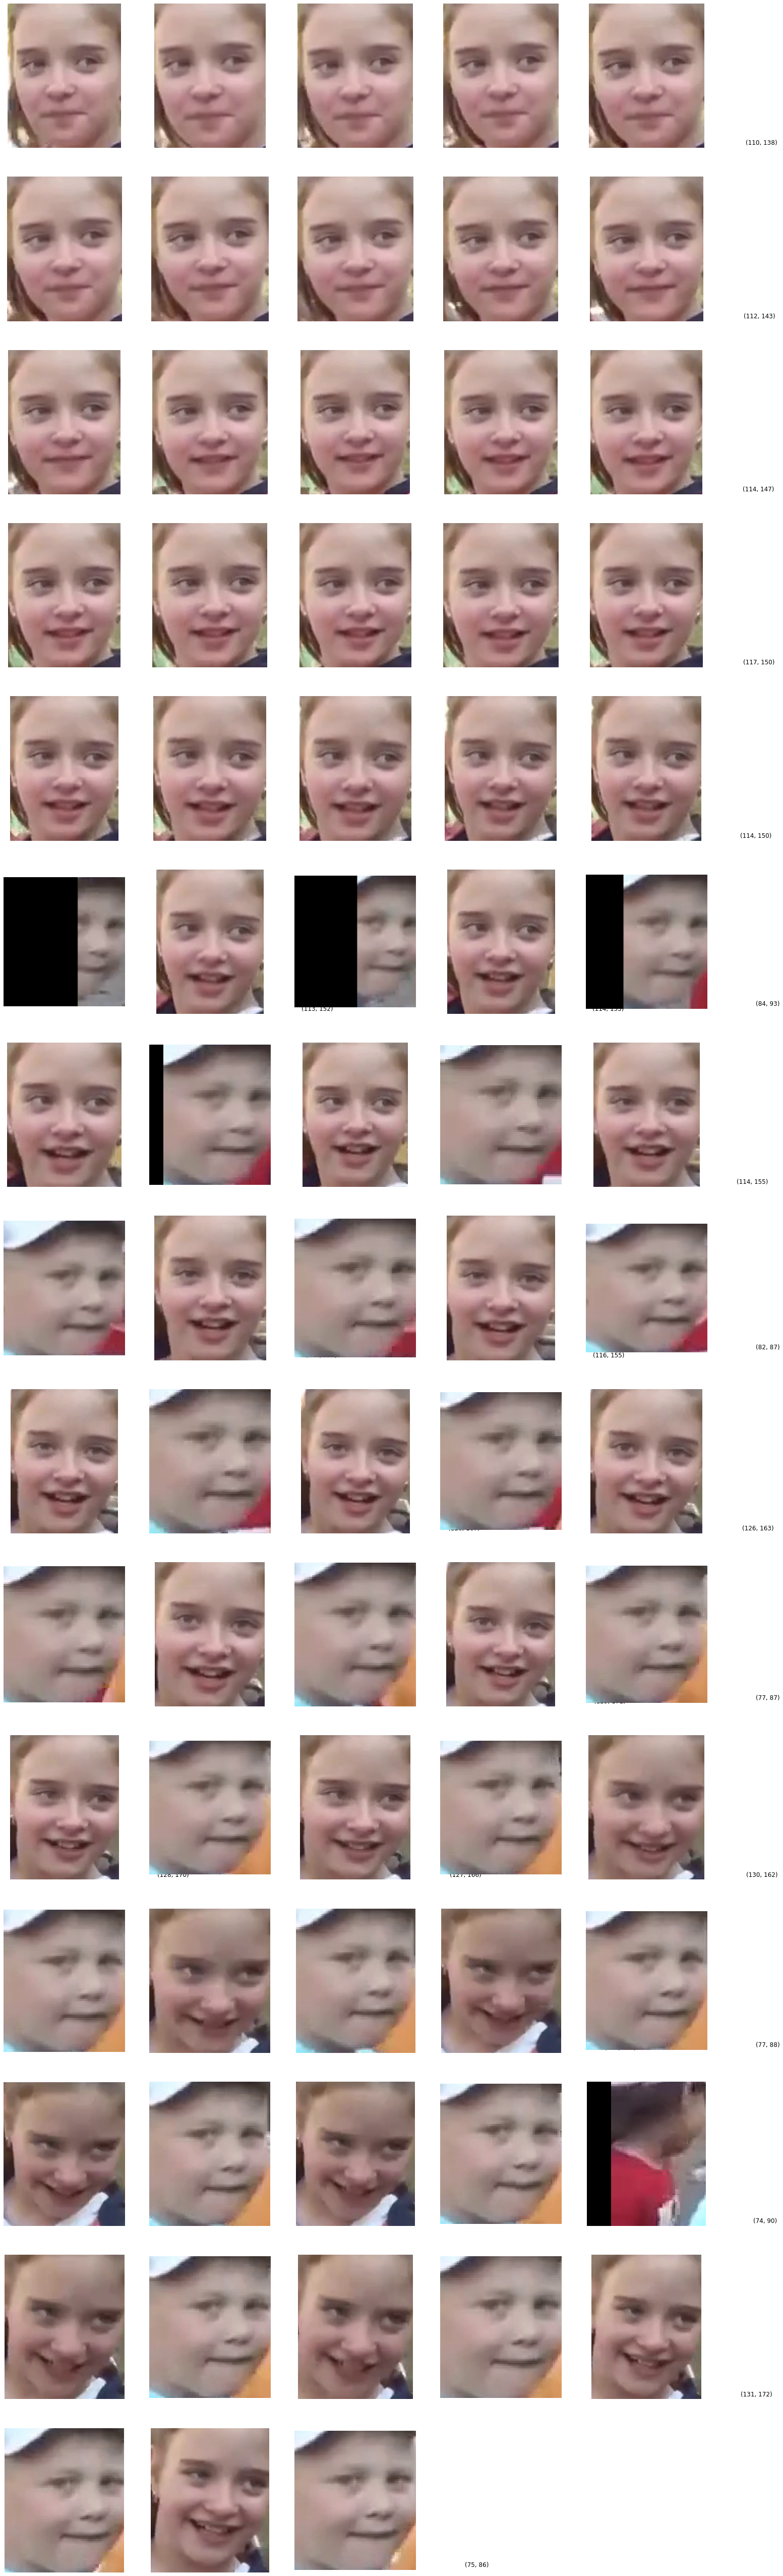

In [214]:
pic_box = plt.figure(figsize=(25,100))

for i, picture in enumerate(fcd.faces_list):
    pic_box.add_subplot(len(fcd.faces_list)//5+2,5,i+1)
    plt.imshow(picture[0])
    plt.title(picture[0].size, x=1.5, y=0)

    plt.axis('off')

plt.show()

In [216]:
# fcd.emotion_model.config

In [247]:
# DeepFace.analyze(img_path = np.array(fcd.faces_list[0][0]), actions = ['age', 'emotion'], enforce_detection=False) # ['emotion']
DeepFace.analyze(img_path = np.array(fcd.faces_list[0][0]), actions = ['age', 'emotion'], enforce_detection=False)['dominant_emotion']

Action: emotion: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


'angry'

In [252]:
df = pd.DataFrame(columns=['photo', 'frame_num', 'person_id', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'dominant_emotion'])

person_list = []
compare_model = 'ArcFace'

for img, frame_num in fcd.faces_list:
    new_record = DeepFace.analyze(img_path = np.array(img), actions = ['age', 'emotion'], enforce_detection=False)['emotion']
    new_record['dominant_emotion'] = DeepFace.analyze(img_path = np.array(fcd.faces_list[0][0]), actions = ['age', 'emotion'], enforce_detection=False)['dominant_emotion']
    new_record['photo'] = np.array(img)
    new_record['frame_num'] = frame_num
    
    if person_list:
        # if not empty person_list
        added_person = 0
        for idx, exist_person in enumerate(person_list):
            # сравниваем img с людьми в person_list (true если одинаковый)
            if DeepFace.verify(img1_path = np.array(exist_person), img2_path = np.array(img), enforce_detection=False, model_name=compare_model)['verified']:
                # значит уже есть в базе - заносим img как уже существующего
                new_record['person_id'] = idx # присваиваем id существующего 
                df = df.append(new_record, ignore_index=True)
                break
            else:
                added_person += 1
        if added_person == len(person_list):
            # add another person into DB
            person_list.append(img)
            new_record['person_id'] = len(person_list) # присваиваем id только что созданного чела 
            print(len(person_list))
            # значит еще в базе - заносим img как нового
            df = df.append(new_record, ignore_index=True)
            pass

    else:
        # add first if no persons
        person_list.append(img)
        # заносим в БД первого
        new_record['person_id'] = 0
        df = df.append(new_record, ignore_index=True)
        print('Уникальных людей:', len(person_list))

Action: emotion: 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


Уникальных людей: 1


Action: emotion: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


2


Action: emotion: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


3


Action: emotion: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


In [253]:
person_list

[<PIL.Image.Image image mode=RGB size=113x144 at 0x7F6844AD6310>,
 <PIL.Image.Image image mode=RGB size=95x101 at 0x7F68413CC290>,
 <PIL.Image.Image image mode=RGB size=75x86 at 0x7F6844C82510>]

In [254]:
df

photo frame_num person_id  \
0   [[[210, 209, 157], [187, 186, 134], [159, 154,...         0         0   
1   [[[161, 143, 122], [161, 143, 122], [162, 141,...         6         0   
2   [[[161, 156, 113], [162, 154, 120], [160, 152,...        12         0   
3   [[[153, 142, 109], [153, 142, 109], [157, 142,...        18         0   
4   [[[161, 146, 126], [162, 147, 127], [162, 146,...        24         0   
..                                                ...       ...       ...   
68  [[[224, 242, 255], [224, 242, 255], [228, 244,...       270         2   
69  [[[148, 122, 108], [145, 122, 107], [146, 123,...       276         0   
70  [[[211, 236, 249], [216, 241, 254], [217, 245,...       276         2   
71  [[[149, 130, 114], [146, 125, 110], [145, 124,...       282         0   
72  [[[218, 238, 252], [220, 240, 254], [222, 242,...       282         2   

           angry       disgust          fear      happy    neutral  \
0   5.928767e+01  1.427711e-01  1.741946e+00   8.839964  19.779471   
1   7.927254e+01  1.737590e+00  6.585178e+00   1.653625   0.791184   
2   3.437741e+01  5.972388e-01  2.139265e+01   0.793588   9.039950   
3   1.533796e+01  3.603016e-01  2.719386e+01   4.155290  17.152196   
4   2.562457e+01  1.727980e+00  6.064152e+00   8.941491  21.107968   
..           ...           ...           ...        ...        ...   
68  7.188411e-04  2.117559e-11  1.816457e-03  99.965864   0.029655   
69  6.595228e-10  3.739409e-13  4.505029e-08  99.991977   0.008028   
70  3.158261e-02  3.476538e-10  1.550620e-02  99.492317   0.437973   
71  6.106340e-07  6.586784e-13  1.825345e-09  99.999833   0.000165   
72  1.643899e-04  4.620721e-13  1.343027e-04  99.987292   0.011547   

             sad      surprise dominant_emotion  
0   1.010182e+01  1.063576e-01            angry  
1   8.879089e+00  1.080801e+00            angry  
2   3.208555e+01  1.713616e+00            angry  
3   2.780284e+01  7.997533e+00            angry  
4   3.331517e+01  3.218670e+00            angry  
..           ...           ...              ...  
68  9.055495e-04  1.041160e-03            angry  
69  1.338815e-08  1.925307e-07            angry  
70  1.998622e-02  2.638950e-03            angry  
71  4.943839e-07  3.400604e-10            angry  
72  6.111511e-05  8.064675e-04            angry  

[73 rows x 11 columns]

In [255]:
df.to_csv('12345.csv', index=False)

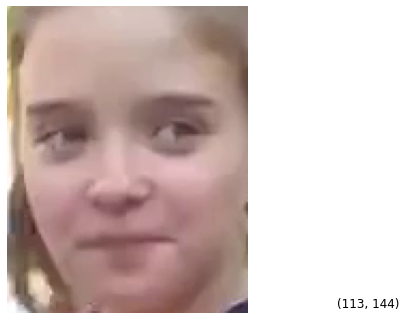

In [224]:
pic_box = plt.figure(figsize=(25,100))

for i, picture in enumerate(person_list):
    pic_box.add_subplot(len(person_list)//5+2,5,i+1)
    plt.imshow(picture)
    plt.title(picture.size, x=1.5, y=0)

    plt.axis('off')

plt.show()

In [23]:
# plt.imshow(Image.open(foto1))